Clustering

In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('processed.csv')

# Convert 'datetime' column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Calculate the 80% quantile datetime for splitting
split_date = df['datetime'].quantile(0.8)

# Split the data into training and testing sets
train = df[df['datetime'] < split_date]
test = df[df['datetime'] >= split_date]

# Optional: print the split info
print(f"Training data shape: {train.shape}")
print(f"Testing data shape: {test.shape}")
print(f"Split date (80% quantile): {split_date}")


Training data shape: (120634, 40)
Testing data shape: (30159, 40)
Split date (80% quantile): 2020-01-09 23:36:00


In [2]:
# Select relevant features
cluster_features = [
    'demand', 'temperature', 'humidity', 'windSpeed', 
    'precipProbability', 'hour', 'is_weekend'
]

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train[cluster_features])

# Add city information as color labels for visualization
city_labels = train['city'].astype('category').cat.codes

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

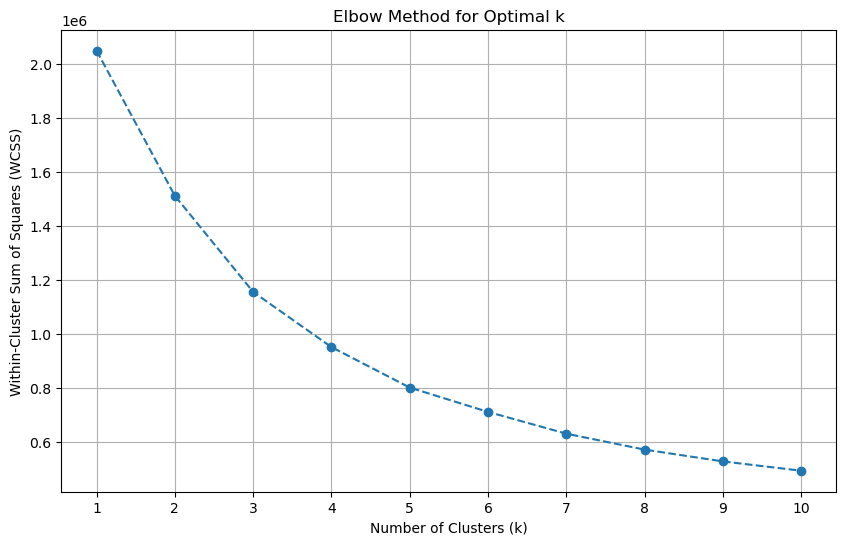

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Get preprocessed numeric features (after scaling)
numeric_features = ['temperature', 'demand', 
                   'apparentTemperature', 'dewPoint', 'humidity', 'pressure',
                   'windSpeed', 'windGust', 'windBearing', 'cloudCover',
                   'uvIndex', 'visibility', 'hour', 'day_of_week', 'month',
                   'demand_lag1', 'demand_rolling_24h']

X_numeric = train[numeric_features].dropna()  # Ensure no missing values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

wcss = []
k_range = range(1, 11)  # Test k from 1 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # WCSS (Inertia)

    plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')

plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


=== CLUSTERING EVALUATION METRICS ===
Silhouette Score (cosine): 0.7926
Calinski-Harabasz Index: 951235.16
Davies-Bouldin Index: 0.4841

Cluster Sizes:
0    38929
1    10872
2    67078
3    19873
4    14041
Name: count, dtype: int64

Total points clustered: 150793


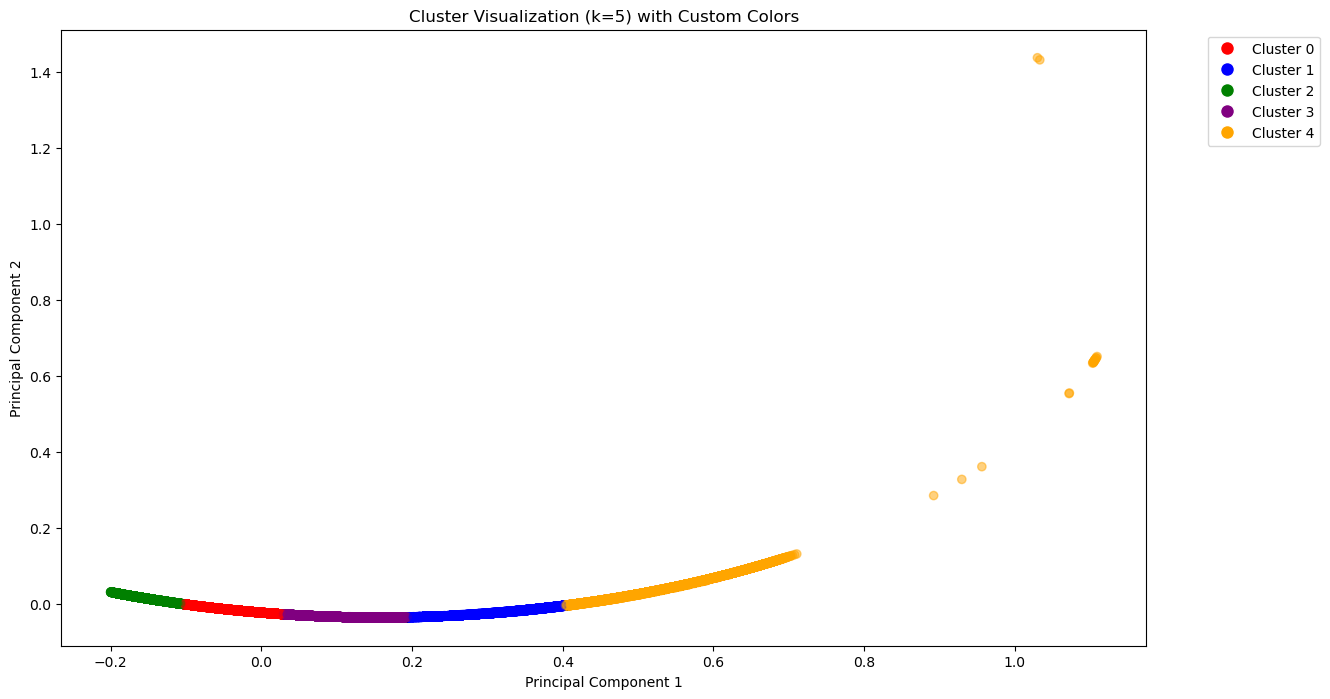

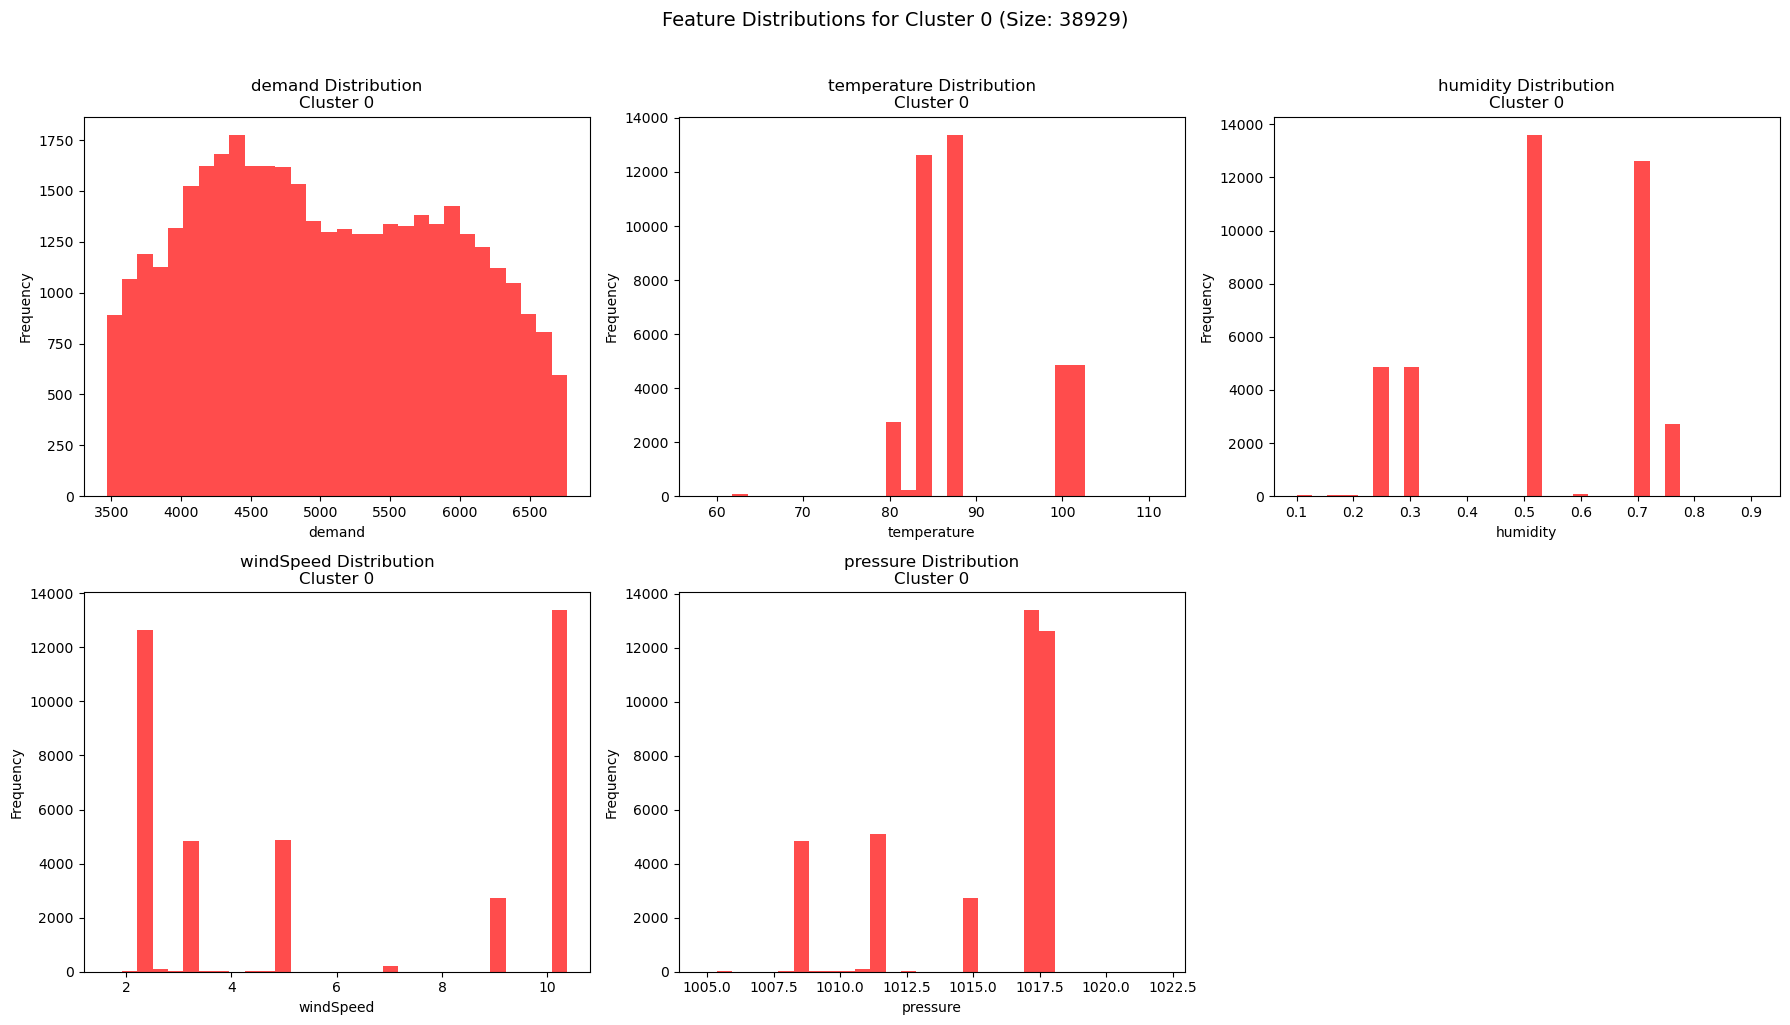

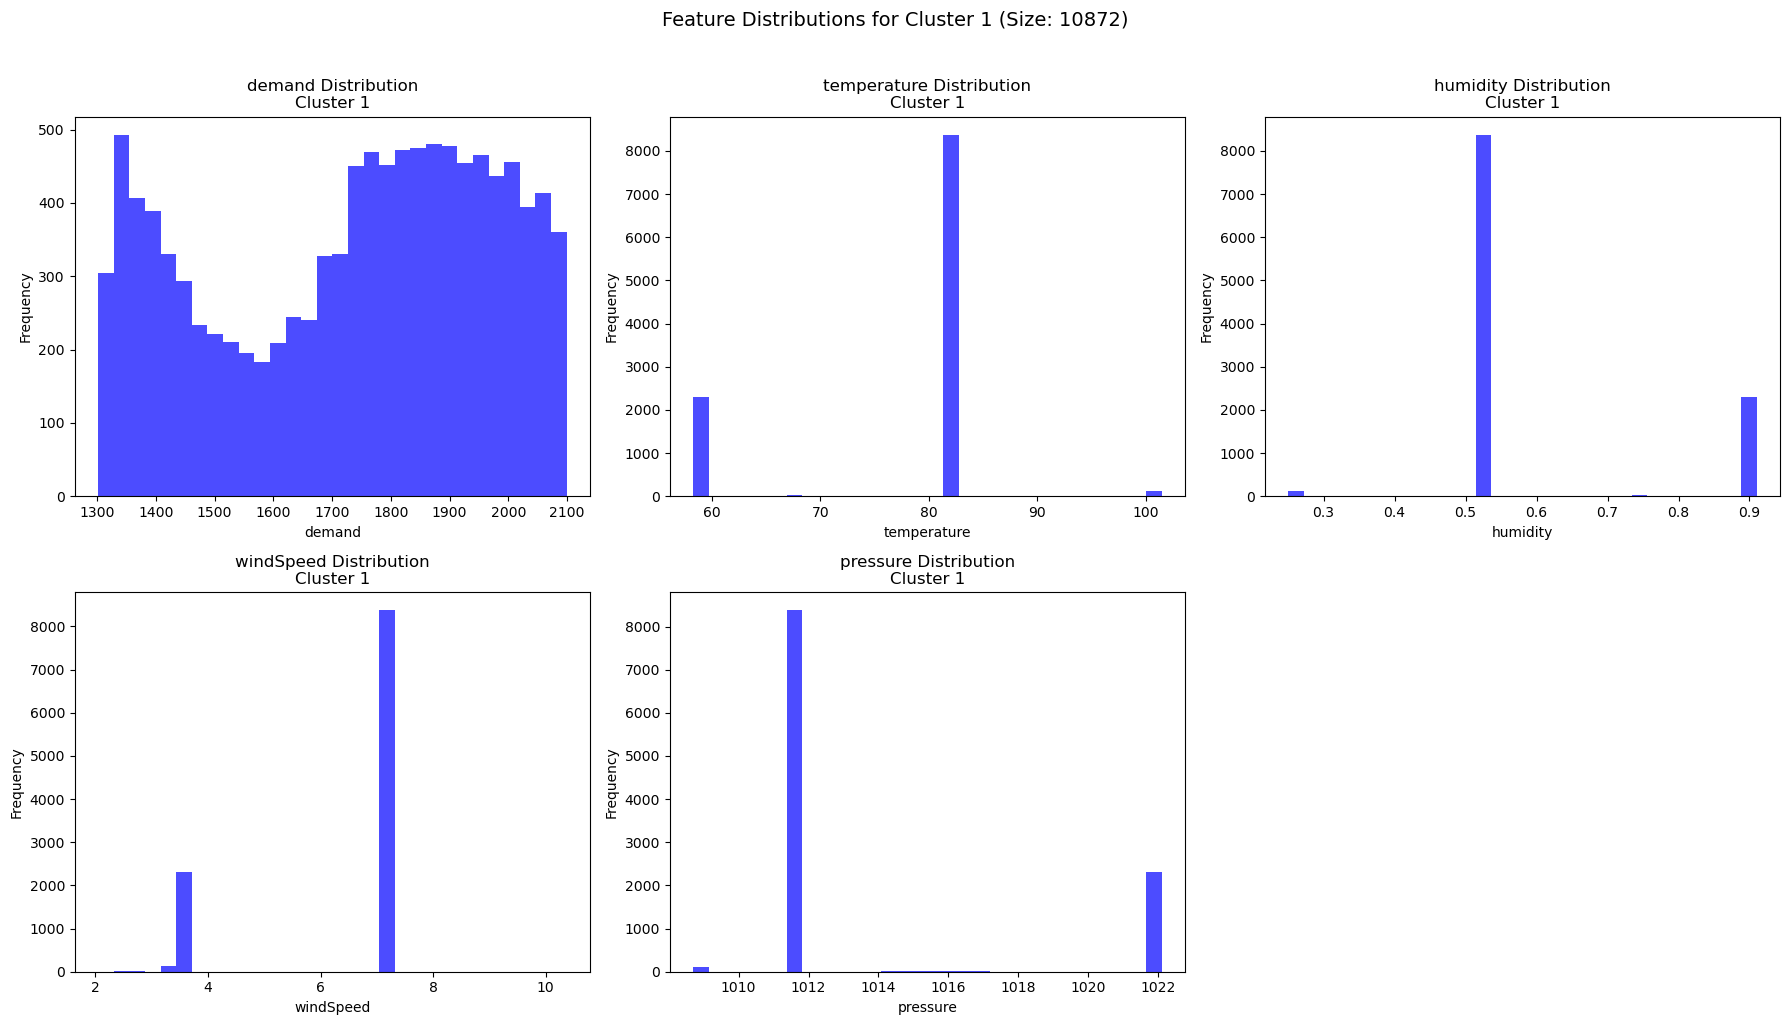

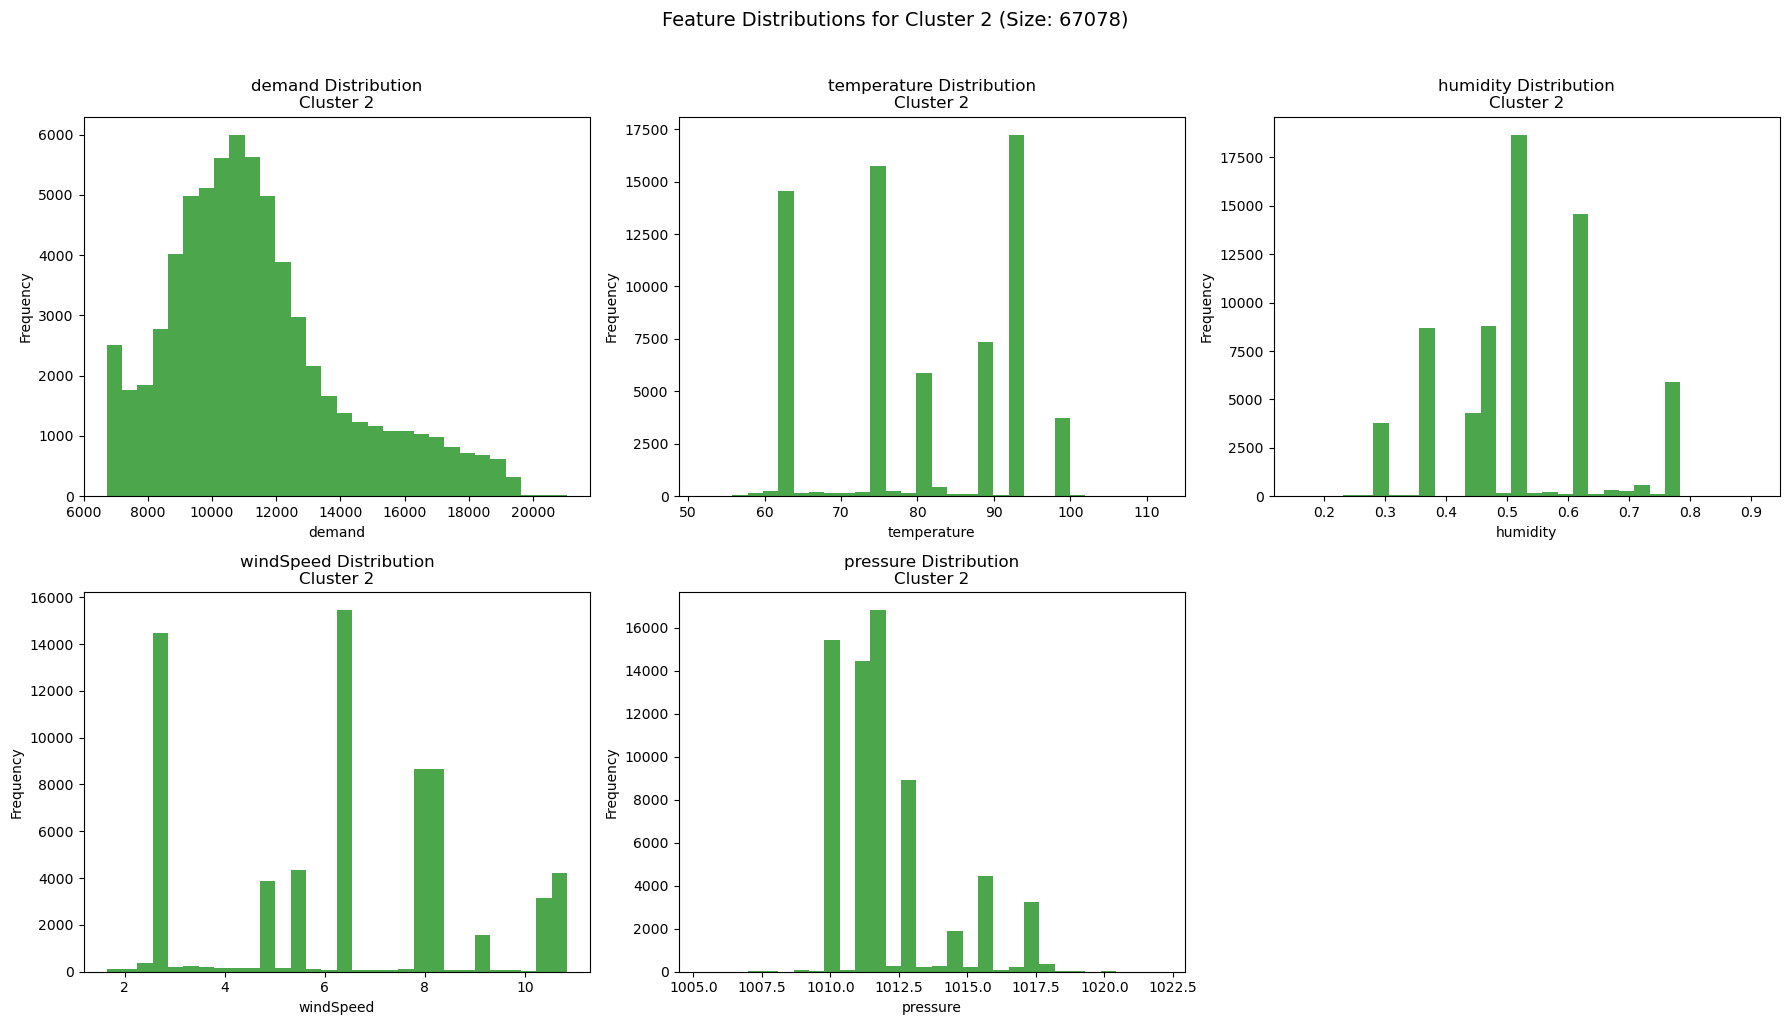

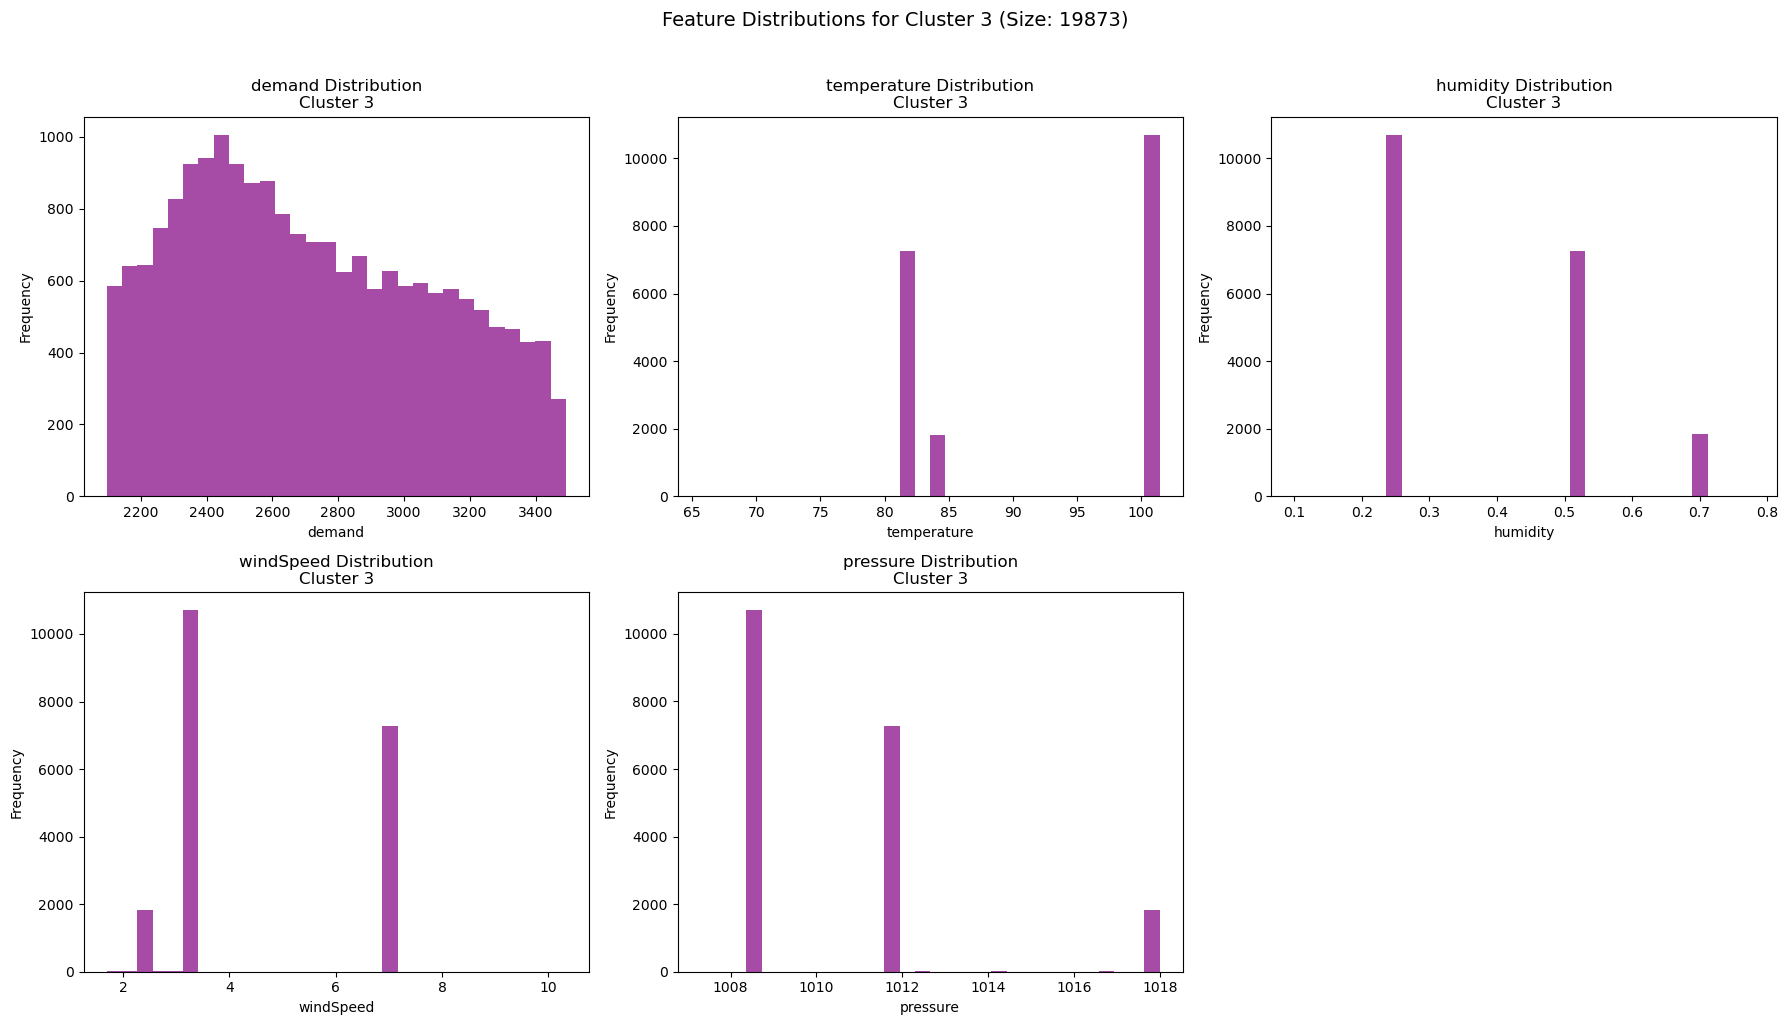

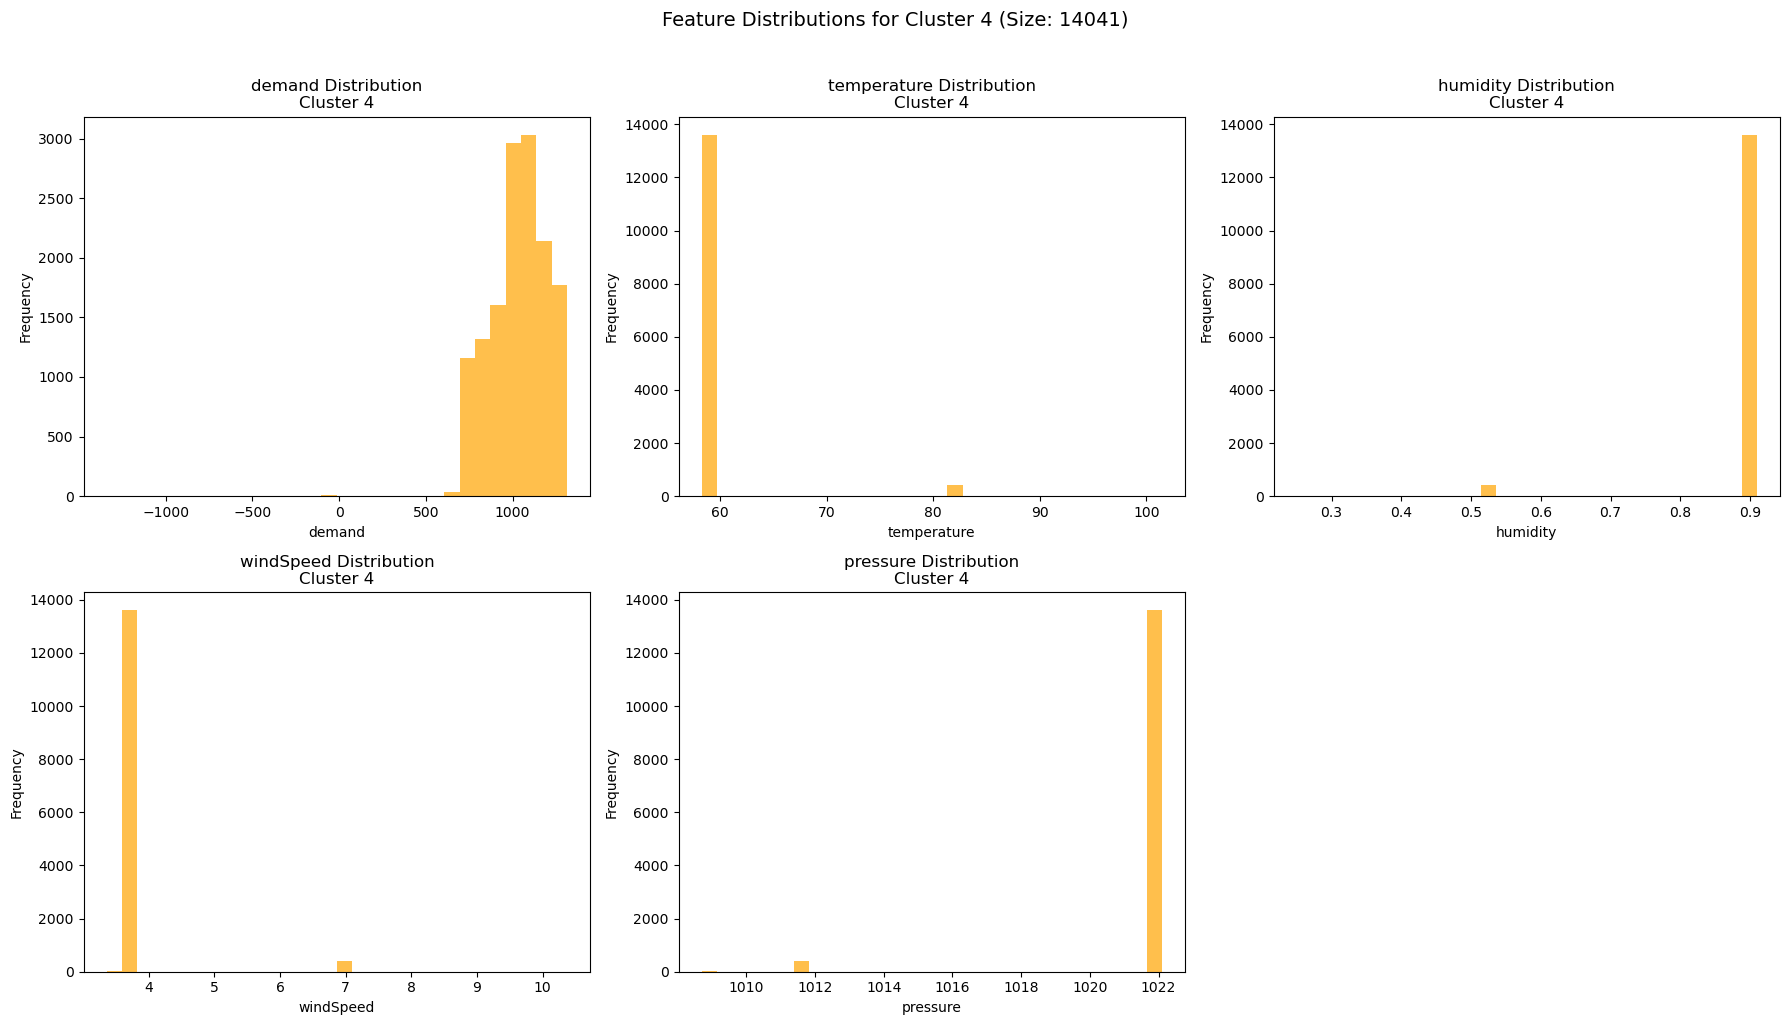


=== CLUSTER STATISTICS ===
               demand                     temperature                    \
                 mean          std  count        mean        std  count   
cluster                                                                   
0         5035.348577   879.946540  38929   89.232750   7.049970  38929   
1         1733.090140   234.209426  10872   77.244565  10.124534  10872   
2        11380.344347  2753.640146  67078   80.311600  12.479467  67078   
3         2714.920898   373.607965  19873   92.666949   9.527923  19873   
4         1034.244142   162.754916  14041   59.028603   4.338450  14041   

         humidity                  windSpeed                      pressure  \
             mean       std  count      mean       std  count         mean   
cluster                                                                      
0        0.537210  0.177226  38929  6.094623  3.502002  38929  1015.415783   
1        0.608235  0.159784  10872  6.300328  1.445897  108

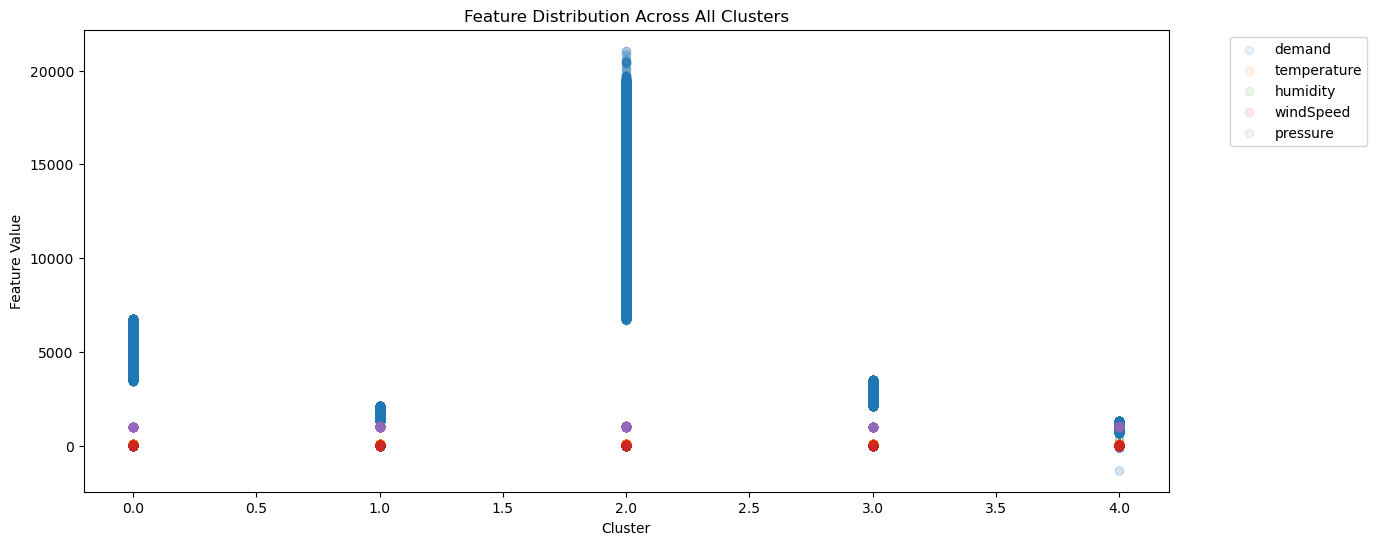

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configuration
CONFIG = {
    "data_path": "processed.csv",
    "features": ['demand', 'temperature', 'humidity', 'windSpeed', 'pressure'],
    "n_clusters": 5,
    "cluster_colors": {
        0: 'red',
        1: 'blue',
        2: 'green',
        3: 'purple',
        4: 'orange'
    }
}

# Load and normalize data
df = pd.read_csv(CONFIG['data_path'])
train_df = df[CONFIG['features']].copy()
train_normalized = normalize(train_df)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=CONFIG['n_clusters'], random_state=42)
cluster_labels = kmeans.fit_predict(train_normalized)
train_df['cluster'] = cluster_labels

# Evaluation Metrics
def print_evaluation_metrics(X, labels):
    print("\n=== CLUSTERING EVALUATION METRICS ===")
    if len(np.unique(labels)) > 1:
        silhouette = silhouette_score(X, labels, metric='cosine')
        print(f"Silhouette Score (cosine): {silhouette:.4f}")
    else:
        print("Silhouette Score: Not computable (only 1 cluster)")

    ch_score = calinski_harabasz_score(X, labels)
    print(f"Calinski-Harabasz Index: {ch_score:.2f}")
    
    db_score = davies_bouldin_score(X, labels)
    print(f"Davies-Bouldin Index: {db_score:.4f}")
    
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    print("\nCluster Sizes:")
    print(cluster_counts)
    print(f"\nTotal points clustered: {len(labels)}")

print_evaluation_metrics(train_normalized, cluster_labels)

# Visualize clusters
def visualize_clusters(data, labels, features):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    colors = [CONFIG['cluster_colors'][label] for label in labels]
    plt.figure(figsize=(14, 8))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors, alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'Cluster Visualization (k={CONFIG["n_clusters"]}) with Custom Colors')
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
                      markerfacecolor=color, markersize=10) 
                     for i, color in CONFIG['cluster_colors'].items()]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

visualize_clusters(train_normalized, cluster_labels, CONFIG['features'])

# Feature distributions
def plot_feature_distributions(df, features, cluster_col='cluster'):
    for cluster in range(CONFIG['n_clusters']):
        plt.figure(figsize=(18, 10))
        cluster_data = df[df[cluster_col] == cluster]
        for i, feature in enumerate(features, 1):
            plt.subplot(2, 3, i)
            plt.hist(cluster_data[feature], bins=30, color=CONFIG['cluster_colors'][cluster], alpha=0.7)
            plt.title(f'{feature} Distribution\nCluster {cluster}')
            plt.xlabel(feature)
            plt.ylabel('Frequency')
        plt.suptitle(f'Feature Distributions for Cluster {cluster} (Size: {len(cluster_data)})', 
                     y=1.02, fontsize=14)
        plt.tight_layout()
        plt.show()

plot_feature_distributions(train_df, CONFIG['features'])

# Cluster statistics
def analyze_clusters(df, cluster_col='cluster'):
    cluster_stats = df.groupby(cluster_col).agg(['mean', 'std', 'count'])
    print("\n=== CLUSTER STATISTICS ===")
    print(cluster_stats)
    
    plt.figure(figsize=(14, 6))
    for feature in CONFIG['features']:
        plt.scatter(df[cluster_col], df[feature], alpha=0.1, label=feature)
    plt.title('Feature Distribution Across All Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Feature Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

analyze_clusters(train_df)


# Predictive Modelling

Data loaded with shape: (150793, 39)
Date range: 2018-01-01 00:00:00 to 2020-05-20 07:00:00

Test period starts at: 2020-04-20 07:00:00
Naive Baseline Performance:
MAE: 272.09
RMSE: 371.02
MAPE: 3.92%

Fitting 3 folds for each of 8 candidates, totalling 24 fits
XGBoost (Tuned) Performance:
MAE: 193.27
RMSE: 271.21
MAPE: 2.88%


Model Comparison:
                MAE        RMSE      MAPE
Naive    272.085403  371.018798  3.916461
XGBoost  193.271820  271.206935  2.883191


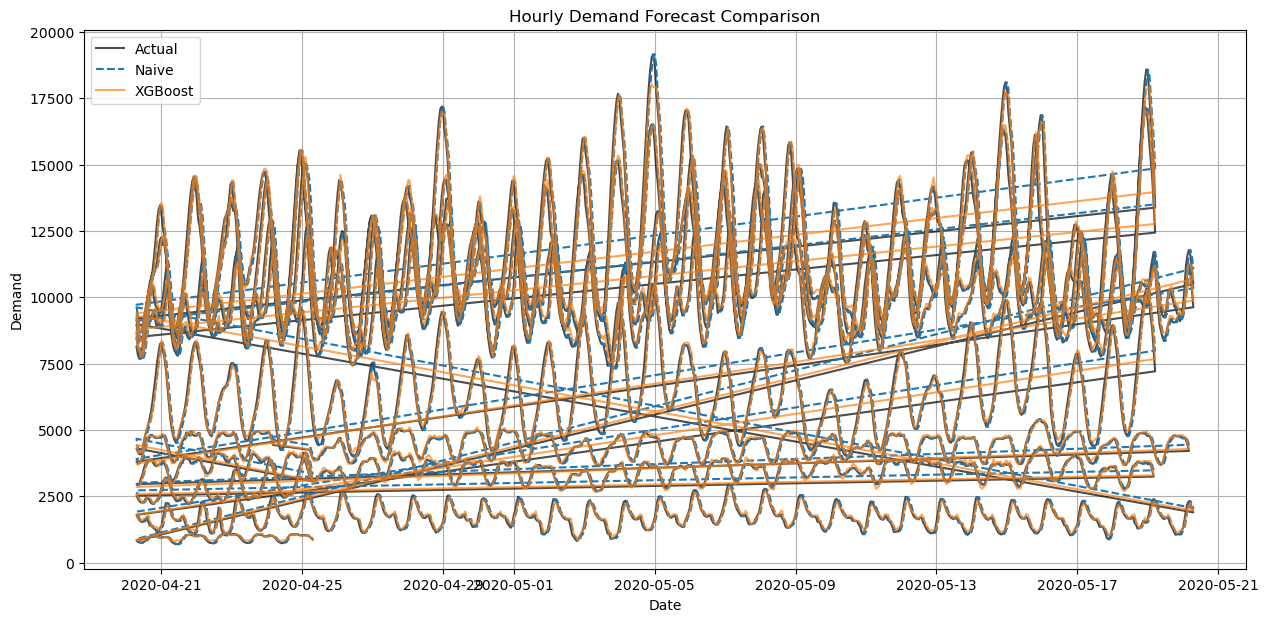

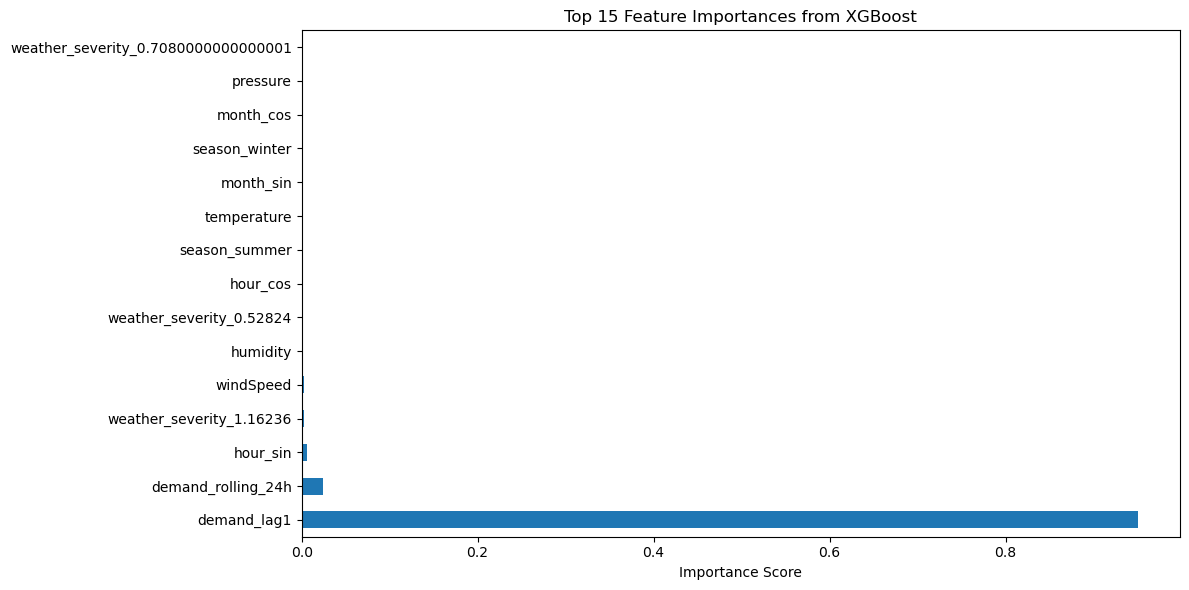


Best model saved as 'best_xgb_model.joblib'


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed, dump, load
import matplotlib.pyplot as plt
import seaborn as sns

# Configure parallel processing
N_JOBS = -1  # Use all cores

# Load and prepare data
def load_data(filepath):
    df = pd.read_csv(filepath)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    return df

# Feature engineering
def create_features(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    return df

# Train-test split by date
def temporal_train_test_split(df, test_date):
    train = df[df.index < test_date]
    test = df[df.index >= test_date].copy()  # Fix SettingWithCopyWarning
    return train, test

# Evaluation metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print()
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Visualization functions
def plot_results(y_test, y_pred_naive, y_pred_xgb):
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='Actual', color='black', alpha=0.7)
    plt.plot(y_test.index, y_pred_naive, label='Naive', linestyle='--')
    plt.plot(y_test.index, y_pred_xgb, label='XGBoost', alpha=0.7)
    plt.title('Hourly Demand Forecast Comparison')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.grid()
    plt.show()

def plot_feature_importance(model, preprocessor, X_train, numeric_features, categorical_features):
    """Visualize feature importance from XGBoost model"""
    # Fit preprocessor to get feature names
    preprocessor.fit(X_train)
    
    # Get feature names after one-hot encoding
    numeric_feature_names = numeric_features
    categorical_feature_names = list(
        preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    )
    feature_names = numeric_feature_names + categorical_feature_names
    
    # Plot top 15 features
    plt.figure(figsize=(12, 6))
    feat_importances = pd.Series(
        model.named_steps['xgbregressor'].feature_importances_,
        index=feature_names
    )
    feat_importances.nlargest(15).plot(kind='barh')
    plt.title('Top 15 Feature Importances from XGBoost')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
# Configuration
DATA_PATH = 'processed.csv'

# Load and prepare data
df = load_data(DATA_PATH)
print(f"Data loaded with shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
    
# Set test period to last 30 days
TEST_DATE = str(df.index.max() - pd.Timedelta(days=30))
print(f"\nTest period starts at: {TEST_DATE}")
    
df = create_features(df)
    
    # Define features
numeric_features = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos',
                       'temperature', 'humidity', 'windSpeed', 'pressure',
                       'demand_lag1', 'demand_rolling_24h']
categorical_features = ['is_weekend', 'season', 'weather_severity']
target = 'demand'
    
    # Temporal train-test split
train, test = temporal_train_test_split(df, TEST_DATE)
X_train, y_train = train[numeric_features + categorical_features], train[target]
X_test, y_test = test[numeric_features + categorical_features], test[target]
    
    # Preprocessing pipeline
preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
])
    
    # 1. Naive Baseline
test['naive_pred'] = test['demand_lag1']  # Properly using .loc would be better for production
y_pred_naive = test['naive_pred']
baseline_metrics = evaluate_model(y_test, y_pred_naive, "Naive Baseline")
    
    # 2. XGBoost (best performing model)
xgb = Pipeline([
        ('preprocessor', preprocessor),
        ('xgbregressor', XGBRegressor(tree_method='hist', n_jobs=N_JOBS))
])
    
param_grid = {
        'xgbregressor__n_estimators': [50, 100],
        'xgbregressor__max_depth': [3, 6],
        'xgbregressor__learning_rate': [0.01, 0.1]
}
    
grid_search = GridSearchCV(
        xgb,
        param_grid,
        cv=TimeSeriesSplit(n_splits=3),
        scoring='neg_mean_absolute_error',
        n_jobs=N_JOBS,
        verbose=1
)
    
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
xgb_metrics = evaluate_model(y_test, y_pred_xgb, "XGBoost (Tuned)")
    
    # Results comparison
results = pd.DataFrame({
        'Naive': baseline_metrics,
        'XGBoost': xgb_metrics
}).T
print("\nModel Comparison:")
print(results)
    
    # Visualization
plot_results(y_test, y_pred_naive, y_pred_xgb)
plot_feature_importance(best_xgb, preprocessor, X_train, numeric_features, categorical_features)
    
    # Save the best model
dump(best_xgb, 'best_xgb_model.joblib')
print("\nBest model saved as 'best_xgb_model.joblib'")
